/var/folders/80/dpnwd7h93_s2rmdn2t1q5n0m0000gn/T/ipykernel_2036/938089061.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


📈 Final Model Performance:
  • RMSE: 0.67
  • MAE: 0.54
  • R² Score: 0.9613


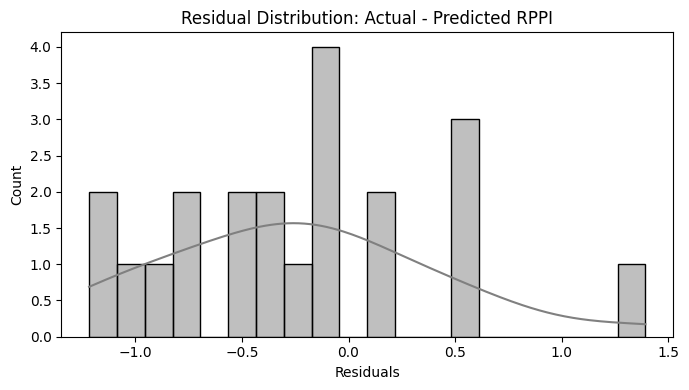

/var/folders/80/dpnwd7h93_s2rmdn2t1q5n0m0000gn/T/ipykernel_2036/938089061.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


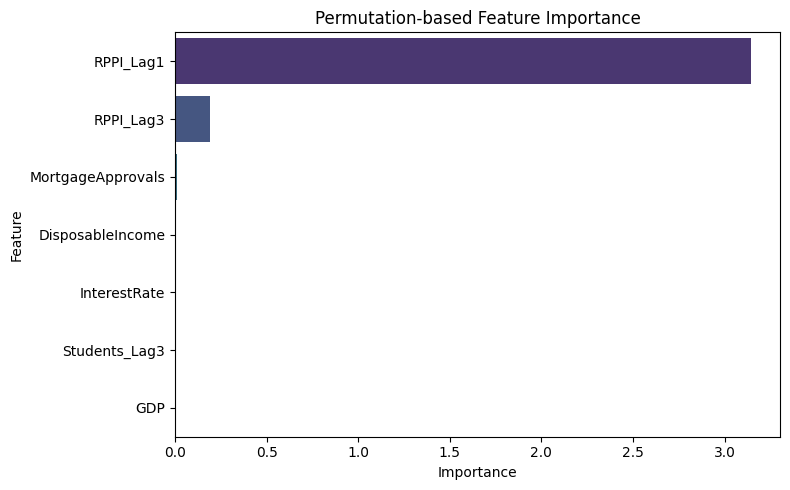

🧪 Naive Lag Benchmark RMSE: 1.18
✅ Improvement over naive lag model: 42.99%


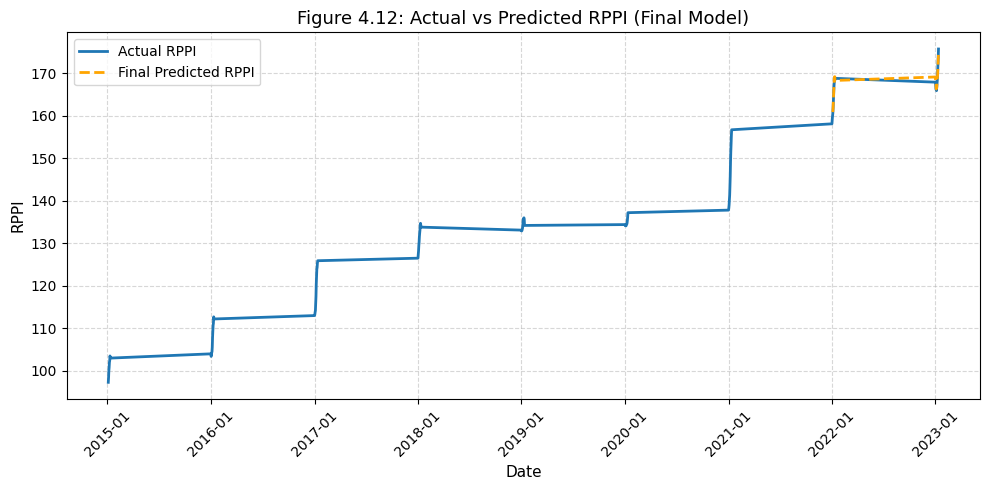

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Load and clean
df = pd.read_csv("cleaned_for_predictive_modeling.csv")
df = df.drop(columns=["Unnamed: 14", "Unnamed: 15"], errors="ignore")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Feature engineering
df["Students_Lag3"] = df["University level students"].shift(3)
df["RPPI_Lag1"] = df["RPPI"].shift(1)
df["RPPI_Lag3"] = df["RPPI"].shift(3)
df = df.dropna()

# Selected features
selected_features = [
    "RPPI_Lag1", "RPPI_Lag3",
    "Students_Lag3", "InterestRate",
    "GDP", "DisposableIncome", "MortgageApprovals"
]
X = df[selected_features]
y = df["RPPI"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time-aware train-test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Model training
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Add predictions
df.loc[y_test.index, "Final_Predicted_RPPI"] = y_pred

# Evaluation metrics
rmse = rmse = mean_squared_error(y_test, y_pred) ** 0.5

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📈 Final Model Performance:")
print(f"  • RMSE: {rmse:.2f}")
print(f"  • MAE: {mae:.2f}")
print(f"  • R² Score: {r2:.4f}")

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True, bins=20, color="grey")
plt.title("Residual Distribution: Actual - Predicted RPPI")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Feature Importance via permutation
perm_results = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': perm_results.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.title("Permutation-based Feature Importance")
plt.tight_layout()
plt.show()

# Benchmark model: naive lag
naive_pred = df.loc[y_test.index, "RPPI_Lag1"]
naive_rmse = mean_squared_error(y_test, naive_pred) ** 0.5
print(f"🧪 Naive Lag Benchmark RMSE: {naive_rmse:.2f}")

# Comparison
improvement = ((naive_rmse - rmse) / naive_rmse) * 100
print(f"✅ Improvement over naive lag model: {improvement:.2f}%")

# Final prediction plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["RPPI"], label="Actual RPPI", linewidth=2)
plt.plot(df.index, df["Final_Predicted_RPPI"], label="Final Predicted RPPI", linestyle="--", linewidth=2, color="orange")

plt.title("Figure 4.12: Actual vs Predicted RPPI (Final Model)", fontsize=13)
plt.xlabel("Date", fontsize=11)
plt.ylabel("RPPI", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# --- Select features/target ---
selected_features = [
    "RPPI_Lag1", "RPPI_Lag3", "Students_Lag3",
    "InterestRate", "GDP", "DisposableIncome", "MortgageApprovals"
]
X = df[selected_features].copy()
y = df["RPPI"].copy()

# --- Time-aware split ---
split_idx = int(len(X) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train,     y_test     = y.iloc[:split_idx], y.iloc[split_idx:]

# --- Standardize: fit on TRAIN only, transform both ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)


In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)

# In-sample (training) fitted values — for Figure 4.3
y_fitted_train = model.predict(X_train)

# Out-of-sample (test) predictions — for Figure 4.13
y_pred_test = model.predict(X_test)

# Attach back to a single series for plotting convenience
plot_df = df.copy()
plot_df["Predicted_Train"] = pd.Series(y_fitted_train, index=y_train.index)
plot_df["Predicted_Test"]  = pd.Series(y_pred_test,   index=y_test.index)


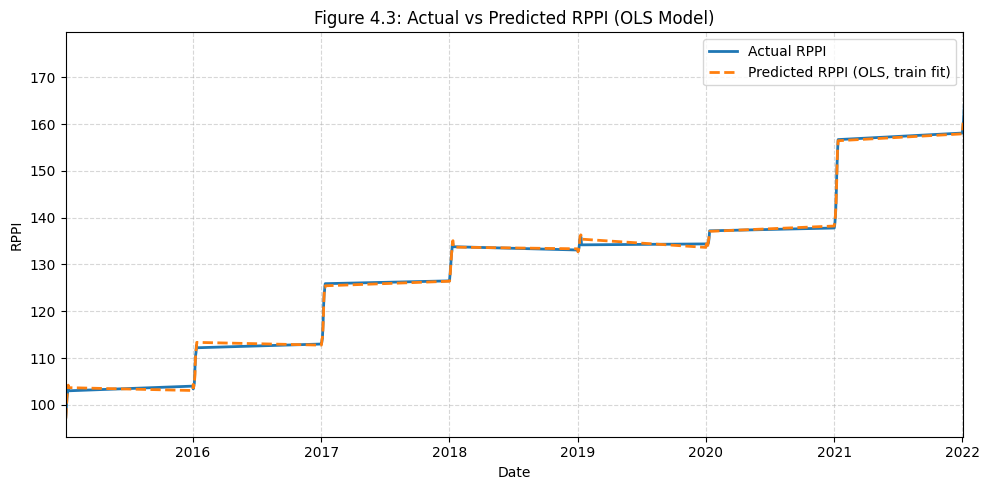

In [6]:
plt.figure(figsize=(10,5))
plt.plot(plot_df.index, plot_df["RPPI"], label="Actual RPPI", linewidth=2)
plt.plot(plot_df.index, plot_df["Predicted_Train"], "--", label="Predicted RPPI (OLS, train fit)", linewidth=2)
plt.xlim(y_train.index.min(), y_train.index.max())
plt.title("Figure 4.3: Actual vs Predicted RPPI (OLS Model)")
plt.xlabel("Date"); plt.ylabel("RPPI")
plt.legend(); plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
# plt.savefig("figure_4_3_actual_vs_predicted_train.png", dpi=300)
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(y_test, y_pred_test)** 0.5
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

naive = plot_df.loc[y_test.index, "RPPI_Lag1"]
naive_rmse = mean_squared_error(y_test, naive) ** 0.5
improvement = (naive_rmse - rmse) / naive_rmse * 100
print(f"Naive RMSE: {naive_rmse:.2f} | Final RMSE: {rmse:.2f} | Improvement: {improvement:.2f}%")


Naive RMSE: 1.18 | Final RMSE: 0.67 | Improvement: 42.99%
